Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
data = pd.read_csv("train.csv")

-------------------------------------------------------------------------------------------------------------

In [3]:
# Сразу удалим столбец, т.к. он заполнен чуть больше чем на половину
data.drop(['Healthcare_1'], axis=1, inplace=True)

In [4]:
# Этажность дома должна быть больше 0
data.loc[(data['HouseFloor']<1)].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,0,2,B,221244.156664
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,0,0,A,337299.867936
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,0,0,B,229778.057902
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,0,7,B,435462.048070
65,11398,62,1.0,41.194188,NaN,0.0,6,0.0,1977,0.072158,B,B,2,629,1,0,0,A,114063.092041
70,10362,27,2.0,79.227049,NaN,0.0,9,0.0,1977,0.072158,B,B,2,629,1,0,0,A,167023.973143
195,4645,54,2.0,76.312851,NaN,0.0,14,0.0,1977,0.006076,B,B,30,5285,0,6,6,B,466730.805333
223,4622,27,2.0,62.153994,36.094352,0.0,5,0.0,1977,0.072158,B,B,2,629,1,0,0,A,194091.992560
252,8139,27,2.0,58.553809,NaN,0.0,7,0.0,1977,0.072158,B,B,2,629,1,0,0,A,177511.314827


In [5]:
data.loc[data['HouseFloor']<1, 'HouseFloor'] = data['Floor']

In [6]:
train, valid = train_test_split(data, test_size=0.2, random_state=103)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 3465 to 5895
Data columns (total 19 columns):
Id               8000 non-null int64
DistrictId       8000 non-null int64
Rooms            8000 non-null float64
Square           8000 non-null float64
LifeSquare       6306 non-null float64
KitchenSquare    8000 non-null float64
Floor            8000 non-null int64
HouseFloor       8000 non-null float64
HouseYear        8000 non-null int64
Ecology_1        8000 non-null float64
Ecology_2        8000 non-null object
Ecology_3        8000 non-null object
Social_1         8000 non-null int64
Social_2         8000 non-null int64
Social_3         8000 non-null int64
Helthcare_2      8000 non-null int64
Shops_1          8000 non-null int64
Shops_2          8000 non-null object
Price            8000 non-null float64
dtypes: float64(7), int64(9), object(3)
memory usage: 1.2+ MB


In [8]:
%%time
train.describe()

CPU times: user 30.6 ms, sys: 135 µs, total: 30.7 ms
Wall time: 29.1 ms


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,8000.000000,8000.000000,8000.000000,8000.000000,6306.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,8421.575750,50.050875,1.889750,56.280472,37.445161,6.329375,8.520875,12.879125,4.491576e+03,0.119064,24.556875,5330.210375,7.876625,1.310000,4.188250,213747.606981
std,4845.962867,43.354812,0.845834,21.242896,96.011015,31.807336,5.260135,6.473485,2.241661e+05,0.119679,17.502759,4010.041069,23.462917,1.493127,4.763286,92457.296634
min,2.000000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,1.000000,1.912000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59877.592523
25%,4239.750000,19.000000,1.000000,41.784346,22.765747,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153637.969754
50%,8433.500000,35.000000,2.000000,52.571358,32.785523,6.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192133.221510
75%,12613.250000,74.000000,2.000000,65.845831,45.191589,9.000000,12.000000,17.000000,2.001000e+03,0.195781,35.000000,7227.000000,4.000000,2.000000,5.250000,249241.451376
max,16797.000000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


In [9]:
%%time
train.corr()

CPU times: user 5.42 ms, sys: 9 µs, total: 5.43 ms
Wall time: 4.48 ms


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
Id,1.000000,0.012614,-0.007558,-0.010720,0.021173,0.023160,0.001507,-0.000525,0.005522,0.022996,-0.002302,-0.003320,-0.007006,-0.001203,-0.007961,0.014078
DistrictId,0.012614,1.000000,0.073442,-0.027356,-0.018696,0.037488,-0.132693,-0.177086,0.015190,0.070227,0.243480,0.165147,0.148509,0.306178,0.176737,0.266214
Rooms,-0.007558,0.073442,1.000000,0.642613,0.117495,0.000797,0.005828,-0.040267,-0.011766,-0.024402,0.080950,0.076832,0.012883,0.062602,0.056226,0.543369
Square,-0.010720,-0.027356,0.642613,1.000000,0.182097,0.003635,0.123425,0.091061,-0.009996,-0.062538,-0.067044,-0.040027,0.034841,-0.024007,0.019446,0.504793
LifeSquare,0.021173,-0.018696,0.117495,0.182097,1.000000,-0.001671,0.024427,0.026254,-0.002253,-0.022839,-0.046205,-0.037884,0.010065,-0.025095,-0.010236,0.072287
KitchenSquare,0.023160,0.037488,0.000797,0.003635,-0.001671,1.000000,-0.012003,-0.011644,0.000942,-0.006398,0.037707,0.032270,-0.013939,0.042823,0.008615,0.022380
Floor,0.001507,-0.132693,0.005828,0.123425,0.024427,-0.012003,1.000000,0.467252,0.001040,-0.021683,-0.051342,-0.023763,-0.000076,-0.067756,0.019043,0.125630
HouseFloor,-0.000525,-0.177086,-0.040267,0.091061,0.026254,-0.011644,0.467252,1.000000,-0.001487,-0.003239,-0.056205,-0.022811,-0.027765,-0.094032,-0.004034,0.086081
HouseYear,0.005522,0.015190,-0.011766,-0.009996,-0.002253,0.000942,0.001040,-0.001487,1.000000,0.001611,0.003473,0.002261,0.001008,0.012651,0.004254,0.004881
Ecology_1,0.022996,0.070227,-0.024402,-0.062538,-0.022839,-0.006398,-0.021683,-0.003239,0.001611,1.000000,0.026795,0.011974,-0.120320,0.020473,-0.071836,-0.060515


----------------------------

In [10]:
train.loc[train['KitchenSquare']>train['Square']/2]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,B,B,2,469,0,0,0,B,189244.249909
5904,673,27,1.0,54.418214,51.498581,51.0,10,17.0,2017,0.072158,B,B,2,629,1,0,0,A,133273.635012
2916,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,3,0,B,445074.956552
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,6,6,B,438708.707579
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,6,6,B,105539.556275
3379,16781,27,1.0,36.138409,36.710539,36.0,19,19.0,2017,0.072158,B,B,2,629,1,0,0,A,131742.536281
5162,11739,27,2.0,61.070298,59.845092,58.0,8,17.0,2016,0.072158,B,B,2,629,1,0,0,A,212188.959537
5816,2271,27,1.0,43.292516,42.835643,40.0,12,11.0,2015,0.211401,B,B,9,1892,0,0,1,B,117296.173704
5849,11624,46,1.0,42.983283,24.224435,37.0,15,16.0,1983,0.188784,B,B,31,6137,4,0,1,B,198450.736353
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,1,9,B,370148.625285


In [11]:
train['KitchenSquare'].mean()

6.329375

In [12]:
train.loc[train['KitchenSquare']>train['Square']/2, 'KitchenSquare'] = train['KitchenSquare'].mean()

In [13]:
train.loc[train['HouseYear']>2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,5,8,B,243028.603096


In [14]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2008
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

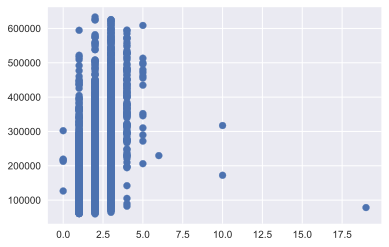

In [15]:
plt.scatter(train['Rooms'], train['Price'])
plt.show()

In [16]:
train.loc[train['Rooms']>5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,5,15,B,317265.323792
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,2,4,B,172329.270863
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,3,8,B,229661.964416


In [17]:
#Исправим завышенное количество комнат
train.loc[train['Rooms']==19, 'Rooms'] = 1
train.loc[train['Rooms']==6, 'Rooms'] = 3
train.loc[train['Rooms']>5, 'Rooms'] = 2

******************************************************************************************************************

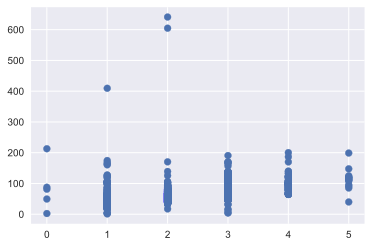

In [18]:
plt.scatter(train['Rooms'], train['Square'])
plt.show()

In [19]:
#Строка с площадью больше 150 и меньше 20 похожи на фейковые
index = train.loc[train['Square']>150].index
train.drop(index, axis=0, inplace=True)

index = train.loc[train['Square']<20].index
train.drop(index, axis=0, inplace=True)

-----------------------

In [20]:
train.loc[train['Rooms']==0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
3911,770,28,0.0,49.483501,NaN,0.0,16,16.0,2015,0.118537,B,B,30,6207,1,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,4.0,1977,0.243205,B,B,5,1564,0,0,0,B,212864.799112
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,0,1,B,219281.918007


In [21]:
#Это похоже на хорошую однушку
train.loc[(train['Rooms']==0) & (train['KitchenSquare']==9.), 'Rooms']=1

#Все остальное считаем мусором
index = train.loc[train['Rooms']==0].index
train.drop(index, axis=0, inplace=True)

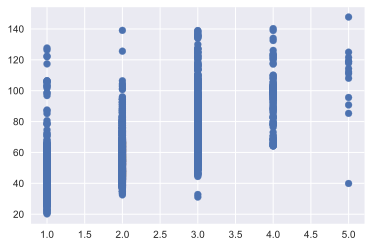

In [22]:
plt.scatter(train['Rooms'], train['Square'])
plt.show()

--------------

In [23]:
train.loc[(train['Rooms']==1) & (train['Square']>60) & (train['KitchenSquare']>5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
6579,16504,27,1.0,72.486741,58.944462,20.0,6,6.0,2017,0.075424,B,B,11,3097,0,0,0,B,195520.319385
3974,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,5,5,B,450706.552655
7409,8824,27,1.0,62.451190,53.618269,14.0,7,6.0,1977,0.075424,B,B,11,3097,0,0,0,B,152956.829998
5111,2085,161,1.0,63.293079,29.389815,18.0,3,9.0,1912,0.014423,B,B,19,3806,4,0,3,B,262279.813915
3216,1394,27,1.0,61.469716,26.684677,15.0,5,6.0,1977,0.075424,B,B,11,3097,0,0,0,B,155874.732400
5653,8500,31,1.0,80.606246,25.299592,29.0,6,40.0,2014,0.151346,B,A,32,5889,10,4,1,B,460492.010947
8824,7496,30,1.0,117.370746,102.187199,6.0,14,40.0,2011,0.000078,B,B,22,6398,141,3,23,B,521829.550445
8050,12555,162,1.0,60.014279,36.656730,10.0,2,6.0,1956,0.236108,B,B,16,3893,27,3,10,B,304424.418395
6019,16578,113,1.0,103.196375,84.122714,20.0,5,25.0,2017,0.050756,B,B,24,5469,1,0,1,B,366400.936549
8181,11887,24,1.0,66.144442,23.803701,18.0,1,18.0,2007,0.111627,B,B,50,12238,8,2,3,B,491816.404219


In [24]:
train['Rooms'].value_counts()

2.0    3090
1.0    2963
3.0    1782
4.0     113
5.0      14
Name: Rooms, dtype: int64

In [25]:
valid['Rooms'].value_counts()

2.0    788
1.0    728
3.0    444
4.0     34
0.0      3
5.0      3
Name: Rooms, dtype: int64

--------------

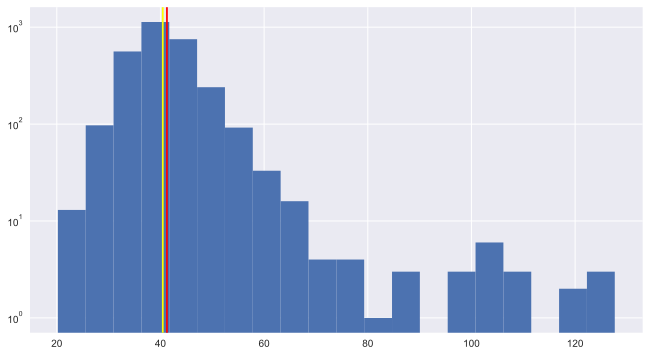

In [26]:
plt.figure(figsize=(11,6))
plt.hist(train.loc[train['Rooms']==1, 'Square'],bins=20, log=True)
plt.axvline(x=train.loc[train['Rooms']==1, 'Square'].mean(),color='red')
plt.axvline(x=train.loc[train['Rooms']==1, 'Square'].median(),color='yellow')

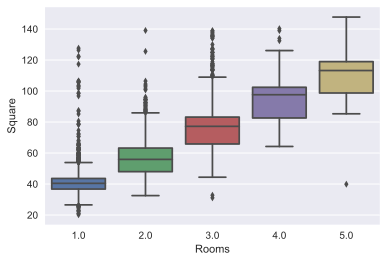

In [27]:
sns.boxplot(x=train['Rooms'], y=train['Square'])

------------------------------------------------------------------------------------------------------------------

In [28]:
def create_model(X_train, X_valid, feats, target, model):
    model.fit(X_train.loc[:,feats], X_train[target])
    pred_train = model.predict(X_train[feats])
    pred_valid = model.predict(X_valid[feats])
    r2_train = r2(X_train[target], pred_train)
    r2_valid = r2(X_valid[target], pred_valid)
    sqrtMSE_train = np.sqrt(MSE(X_train[target], pred_train))
    sqrtMSE_valid = np.sqrt(MSE(X_valid[target], pred_valid))
    return [[r2_train, sqrtMSE_train],
            [r2_valid, sqrtMSE_valid]]
    

-----------------

Построим мервую модель на сырых данных

In [29]:
train_1 = pd.get_dummies(train)
valid_1 = pd.get_dummies(valid)

In [30]:
train_1.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [31]:
model_RF = RF(n_estimators=55, max_depth=6, random_state=103)

In [32]:
feats=['DistrictId', 'Rooms', 'Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 
       'Helthcare_2', 'Shops_1', 'Ecology_2_A','Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 
       'Shops_2_A', 'Shops_2_B']

In [33]:
create_model(train_1, valid_1, feats, 'Price', model_RF)

[[0.7062455732846467, 49992.18451910225],
 [0.6680280782493568, 54446.72199977605]]

In [34]:
model_RF

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=None,
           oob_score=False, random_state=103, verbose=0, warm_start=False)

------------------------------------------------------------------------------------------------------------------

In [35]:
train2 = train_1.copy()
valid2 = valid_1.copy()

In [36]:
ClasterField2 = ['Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B',
'Social_1', 'Social_2', 'Social_3', 
'Shops_2_A', 'Shops_2_B']

In [37]:
scaler2 = MinMaxScaler()
train2_scaled = scaler2.fit_transform(train2[ClasterField2])
train2_scaled

array([[1.49756148e-04, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.38268129e-01, 0.00000000e+00, 1.00000000e+00, ...,
        7.09219858e-03, 1.00000000e+00, 0.00000000e+00],
       [8.39074313e-01, 0.00000000e+00, 1.00000000e+00, ...,
        2.12765957e-02, 0.00000000e+00, 1.00000000e+00],
       ...,
       [4.05086338e-01, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.44077307e-01, 0.00000000e+00, 1.00000000e+00, ...,
        2.12765957e-02, 0.00000000e+00, 1.00000000e+00],
       [2.86790231e-01, 0.00000000e+00, 1.00000000e+00, ...,
        1.41843972e-02, 0.00000000e+00, 1.00000000e+00]])

Text(0.5, 1.0, 'INERTIA')

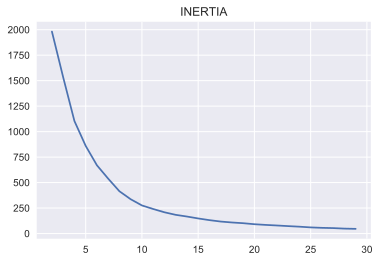

In [38]:
inertia_arr = []
for i in range(2,30):
    temp_model = KMeans(n_clusters=i,random_state=103)
    temp_model.fit(train2_scaled)
    temp_inertia = temp_model.inertia_
    #print(temp_inertia)
    inertia_arr.append(temp_inertia)

plt.plot([i for i in range(2,30)],inertia_arr)
plt.title('INERTIA')

In [39]:
model_AC2 = AgglomerativeClustering(n_clusters=25)

In [40]:
train2['cluster'] = model_AC2.fit_predict(train2_scaled)

plt.scatter(data['HouseYear'],data['DistrictId'],c=train['cluster'])
plt.xlabel('HouseYear')
plt.ylabel('DistrictId')
plt.title('Train')

In [41]:
knn2 = KNeighborsClassifier(n_neighbors=25)

In [42]:
knn2.fit(train2_scaled, train2['cluster'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

In [43]:
valid2[ClasterField2].columns

Index(['Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B',
       'Social_1', 'Social_2', 'Social_3', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [44]:
valid2_scaled = scaler2.transform(valid2[ClasterField2])

In [45]:
valid2['cluster'] = knn2.predict(valid2_scaled)

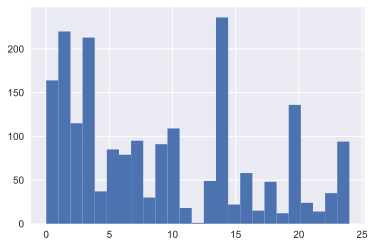

In [46]:
valid2['cluster'].hist(bins=25);

------------------------------------------------------------------------------------------------------------------

In [47]:
feats2=['DistrictId', 'Rooms', 'Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Helthcare_2', 
       'Shops_1', 'cluster'] 

In [48]:
model_RF2 = RF(n_estimators=90, max_depth=20, random_state=103)

In [49]:
create_model(train2, valid2, feats2, 'Price', model_RF2)

[[0.9570267209118652, 19120.936165878],
 [0.7249885812463934, 49556.02061091589]]

----------------

In [50]:
train3 = train_1.copy()
valid3 = valid_1.copy()

In [51]:
train3.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
3465,15683,30,2.0,66.829029,NaN,1.0,4,17.0,1977,0.000078,...,141,3,23,189266.166676,0,1,0,1,0,1
2899,9019,27,3.0,82.857534,NaN,10.0,5,20.0,1977,0.072158,...,1,0,0,244604.216892,0,1,0,1,1,0
4697,10600,58,1.0,54.728124,NaN,1.0,5,9.0,1977,0.437885,...,3,0,5,102859.934359,0,1,0,1,0,1
1747,9230,43,1.0,35.094212,16.958699,5.0,4,5.0,1960,0.015017,...,59,0,8,243727.266658,0,1,0,1,0,1
3388,12541,58,2.0,67.888644,39.823438,1.0,8,12.0,1977,0.437885,...,3,0,5,158618.476812,0,1,0,1,0,1
4477,15424,27,1.0,51.634838,42.948082,1.0,17,18.0,2015,0.017647,...,0,0,0,146489.549570,0,1,0,1,0,1
9331,8614,30,2.0,67.649879,NaN,1.0,13,17.0,1977,0.000078,...,141,3,23,183595.406754,0,1,0,1,0,1
4014,16234,27,2.0,57.943437,60.671325,10.0,16,17.0,2015,0.211401,...,0,0,1,126779.219036,0,1,0,1,0,1
3674,16327,6,1.0,48.374178,NaN,1.0,24,25.0,1977,0.243205,...,0,0,0,145915.951376,0,1,0,1,0,1
5853,3235,142,3.0,57.281088,39.006810,5.0,1,5.0,1961,0.051942,...,7,2,0,234382.745087,0,1,0,1,0,1


In [52]:
train3['KitchenSquare'].mean()

5.69022552436574

In [53]:
# Заменим площади кухни меньше 2 на пустые значения
train3.loc[(train3['KitchenSquare']<2), 'KitchenSquare'] = np.NaN 

In [54]:
train3['KitchenSquare'].mean()

7.972512072295809

In [55]:
# Найдем среднюю площадь кухни в зависимости от года постройки и количества комнат
data3_stat3 = train3.groupby(['Rooms', 'HouseYear'],as_index=False).agg({'KitchenSquare':'mean'}).rename(columns={'KitchenSquare':'mean_KitchenSquare2'})

data3_stat3[data3_stat3['HouseYear'] > 1969].head(10)

,Rooms,HouseYear,mean_KitchenSquare2
23,1.0,1970,6.930233
24,1.0,1971,6.833247
25,1.0,1972,7.325581
26,1.0,1973,7.090909
27,1.0,1974,6.711538
28,1.0,1975,7.000000
29,1.0,1976,7.303030
30,1.0,1977,9.081334
31,1.0,1978,7.243902
32,1.0,1979,7.656250


In [56]:
train3 = train3.merge(data3_stat3, on=['Rooms', 'HouseYear'], how='left')

In [57]:
train3[['KitchenSquare','mean_KitchenSquare2']].corr()

,KitchenSquare,mean_KitchenSquare2
KitchenSquare,1.000000,0.699055
mean_KitchenSquare2,0.699055,1.000000


In [58]:
train3[['HouseYear', 'Rooms', 'KitchenSquare', 'mean_KitchenSquare2']].head(10)

,HouseYear,Rooms,KitchenSquare,mean_KitchenSquare2
0,1977,2.0,NaN,8.989691
1,1977,3.0,10.0,8.604392
2,1977,1.0,NaN,9.081334
3,1960,1.0,5.0,6.478261
4,1977,2.0,NaN,8.989691
5,2015,1.0,NaN,10.193706
6,1977,2.0,NaN,8.989691
7,2015,2.0,10.0,10.701013
8,1977,1.0,NaN,9.081334
9,1961,3.0,5.0,6.588235


Странный результат для однушек 1977 - средняя площадь кухни больше чем для двушек и трешек того же года. Пока не понятно что с этим делать

In [59]:
train3['KitchenSquare'] = train3['KitchenSquare'].fillna(train3['mean_KitchenSquare2'])
train3['KitchenSquare'] = train3['KitchenSquare'].fillna(train3['KitchenSquare'].mean()) 

In [60]:
train3[['KitchenSquare', 'Rooms']].describe()

,KitchenSquare,Rooms
count,7962.000000,7962.00000
mean,8.411521,1.88533
std,2.259593,0.80962
min,2.000000,1.00000
25%,7.000000,1.00000
50%,8.989691,2.00000
75%,9.534984,2.00000
max,43.000000,5.00000


In [61]:
# В валидационной выборке обработаем прощади кухни
valid3.loc[(valid3['KitchenSquare']<2), 'KitchenSquare'] = np.NaN 

In [62]:
valid3 = valid3.merge(data3_stat3, on=['Rooms', 'HouseYear'], how='left')
valid3['KitchenSquare'] = valid3['KitchenSquare'].fillna(valid3['mean_KitchenSquare2'])
valid3['KitchenSquare'] = valid3['KitchenSquare'].fillna(train3['KitchenSquare'].mean()) 

In [63]:
ClasterField3 = ['Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B',
'Social_1', 'Social_2', 'Social_3', 'Shops_2_A', 'Shops_2_B']

In [64]:
scaler3 = MinMaxScaler()
train3_scaled = scaler3.fit_transform(train3.loc[:, ClasterField3])
train3_scaled

array([[1.49756148e-04, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.38268129e-01, 0.00000000e+00, 1.00000000e+00, ...,
        7.09219858e-03, 1.00000000e+00, 0.00000000e+00],
       [8.39074313e-01, 0.00000000e+00, 1.00000000e+00, ...,
        2.12765957e-02, 0.00000000e+00, 1.00000000e+00],
       ...,
       [4.05086338e-01, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.44077307e-01, 0.00000000e+00, 1.00000000e+00, ...,
        2.12765957e-02, 0.00000000e+00, 1.00000000e+00],
       [2.86790231e-01, 0.00000000e+00, 1.00000000e+00, ...,
        1.41843972e-02, 0.00000000e+00, 1.00000000e+00]])

Text(0.5, 1.0, 'INERTIA')

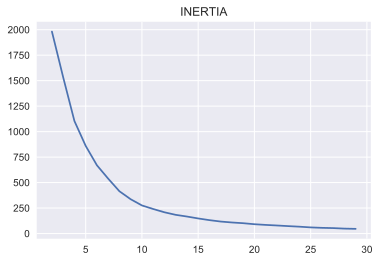

In [65]:
inertia_arr = []
for i in range(2,30):
    temp_model = KMeans(n_clusters=i, random_state=103)
    temp_model.fit(train3_scaled)
    temp_inertia = temp_model.inertia_
    #print(temp_inertia)
    inertia_arr.append(temp_inertia)

plt.plot([i for i in range(2,30)], inertia_arr)
plt.title('INERTIA')

In [66]:
model_AC3 = AgglomerativeClustering(n_clusters=25)
# с n_clusters=25 получил результат лучше чем с 7, 10, 15, 20, больше уже не сильно влияет на результат 

In [67]:
train3['cluster'] = model_AC3.fit_predict(train3_scaled)

In [68]:
knn3 = KNeighborsClassifier(n_neighbors=25)

In [69]:
knn3.fit(train3_scaled, train3['cluster'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

In [70]:
valid3.loc[:, ClasterField3].columns

Index(['Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B',
       'Social_1', 'Social_2', 'Social_3', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [71]:
valid3_scaled = scaler3.transform(valid3[ClasterField3])

In [72]:
valid3['cluster'] = knn3.predict(valid3_scaled)

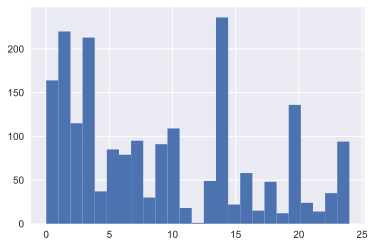

In [73]:
valid3['cluster'].hist(bins=25);

In [74]:
valid3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 24 columns):
Id                     2000 non-null int64
DistrictId             2000 non-null int64
Rooms                  2000 non-null float64
Square                 2000 non-null float64
LifeSquare             1581 non-null float64
KitchenSquare          2000 non-null float64
Floor                  2000 non-null int64
HouseFloor             2000 non-null float64
HouseYear              2000 non-null int64
Ecology_1              2000 non-null float64
Social_1               2000 non-null int64
Social_2               2000 non-null int64
Social_3               2000 non-null int64
Helthcare_2            2000 non-null int64
Shops_1                2000 non-null int64
Price                  2000 non-null float64
Ecology_2_A            2000 non-null uint8
Ecology_2_B            2000 non-null uint8
Ecology_3_A            2000 non-null uint8
Ecology_3_B            2000 non-null uint8
Shops_2_A          

------------------------------------------------------------------------------------------------------------------

In [75]:
feats3 = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Helthcare_2', 'Shops_1', 'cluster'] 

In [76]:
model_RF3 = RF(n_estimators=90, max_depth=20, random_state=103)

In [77]:
create_model(train3, valid3, feats3, 'Price', model_RF3)

[[0.956996931864089, 19127.562327723543],
 [0.7226529846396329, 49766.00856157859]]

------

-----------

In [78]:
test = pd.read_csv("test.csv")
test.drop(['Healthcare_1'], axis=1, inplace=True)
test.drop(['LifeSquare'], axis=1, inplace=True)

In [79]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(5), int64(9), object(3)
memory usage: 664.1+ KB


In [80]:
test.describe()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.00000,23.000000


In [81]:
test.loc[(test['HouseFloor']<1)].head(10)

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
22,12694,27,3.0,83.670032,0.0,8,0.0,2015,0.072158,B,B,2,629,1,0,0,A
24,8968,27,2.0,69.849239,0.0,3,0.0,1977,0.011654,B,B,4,915,0,0,0,B
30,2982,6,2.0,63.460684,0.0,13,0.0,1977,0.243205,B,B,5,1564,0,0,0,B
32,2449,1,1.0,66.426585,0.0,14,0.0,1977,0.007122,B,B,1,264,0,0,1,B
46,12309,45,1.0,42.899569,0.0,25,0.0,1977,0.195781,B,B,23,5212,6,3,2,B
78,6553,34,5.0,122.375273,0.0,9,0.0,1977,0.069753,B,B,53,13670,4,1,11,B
113,5032,30,1.0,50.738045,0.0,5,0.0,1977,0.000078,B,B,22,6398,141,3,23,B
120,12743,27,1.0,40.407390,0.0,9,0.0,1977,0.211401,B,B,9,1892,0,0,1,B
130,5746,62,1.0,44.021356,0.0,13,0.0,1977,0.072158,B,B,2,629,1,0,0,A
132,14834,27,3.0,56.310351,0.0,19,0.0,1977,0.072158,B,B,2,629,1,0,0,A


In [82]:
test.loc[(test['HouseFloor']<1), 'HouseFloor'] = test['Floor']

In [83]:
test.loc[(test['Rooms']<1)|(test['Rooms']>5)]

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6.0,110.750226,0.0,2,2.0,2015,0.014073,B,B,2,475,0,0,0,B
2406,3343,58,0.0,116.824201,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,0,5,B
2524,10729,27,0.0,76.345154,12.0,14,14.0,1977,0.017647,B,B,2,469,0,0,0,B
3217,4058,27,6.0,223.453689,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,1,4,B
3398,1435,111,17.0,52.866107,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,2,4,B


In [84]:
test.loc[(test['Rooms']==17), 'Rooms'] = 2
test.loc[(test['Rooms']<1)|(test['Rooms']>5), 'Rooms'] = 5

In [85]:
test.loc[(test['KitchenSquare']<2), 'KitchenSquare'] = np.NaN 

In [86]:
test = test.merge(data3_stat3, on=['Rooms', 'HouseYear'], how='left')
test['KitchenSquare'] = test['KitchenSquare'].fillna(test['mean_KitchenSquare2'])
test['KitchenSquare'] = test['KitchenSquare'].fillna(train3['KitchenSquare'].mean()) 

In [87]:
train['KitchenSquare'].mean()

5.69022552436574

In [88]:
test['KitchenSquare'].mean()

8.579393818377815

In [89]:
test1 = pd.get_dummies(test)

In [90]:
test1_scaled = scaler3.transform(test1[ClasterField3])

In [91]:
test1['cluster'] = knn3.predict(test1_scaled)

In [92]:
test1['Price'] = model_RF3.predict(test1[feats3])

In [93]:
test1[['Id','Price']].to_csv('VIsupov_predictions.csv', index = None)

In [94]:
test1[feats2].head(20)

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Helthcare_2,Shops_1,cluster
0,58,2.0,49.882643,6.000000,6,14.0,1972,0,0,6
1,74,2.0,69.263183,8.989691,6,1.0,1977,0,2,0
2,190,1.0,13.597819,12.000000,2,5.0,1909,5,5,8
3,47,2.0,73.046609,9.000000,22,22.0,2007,3,3,1
4,27,1.0,47.527111,10.438388,17,17.0,2017,0,0,24
5,53,1.0,40.675627,9.081334,21,21.0,1977,1,3,3
6,23,2.0,68.099538,8.989691,2,17.0,1977,0,2,0
7,32,2.0,48.193897,6.000000,5,14.0,1972,3,11,7
8,96,3.0,72.277106,9.000000,17,17.0,1997,1,4,2
9,6,3.0,80.219400,9.000000,13,17.0,2014,0,0,20
